# GPR

In [1]:
# define GPR
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

class GPR:

    def __init__(self, optimize=True):
        self.is_fit = False
        self.train_X, self.train_y = None, None
        self.params = {"l": 1., "sigma_f": 0.1}
        self.optimize = optimize


    def fit(self, X, y):
        # store train data
        self.train_X = np.asarray(X)
        self.train_y = np.asarray(y)

         # hyper parameters optimization
        def negative_log_likelihood_loss(params):
            self.params["l"], self.params["sigma_f"] = params[0], params[1]
            Kyy = self.kernel(self.train_X, self.train_X) + 1e-8 * np.eye(len(self.train_X))
            loss = 0.5 * self.train_y.T.dot(np.linalg.inv(Kyy)).dot(self.train_y) + 0.5 * np.linalg.slogdet(Kyy)[1] + 0.5 * len(self.train_X) * np.log(2 * np.pi)
            return loss.ravel()

        if self.optimize:
            res = minimize(negative_log_likelihood_loss, [self.params["l"], self.params["sigma_f"]],
                   bounds=((1e-4, 1e4), (1e-4, 1e4)),
                   #method='SLSQP')
                   method='L-BFGS-B')
                   #method='Powell')
            self.params["l"], self.params["sigma_f"] = res.x[0], res.x[1]

        self.is_fit = True

    def predict(self, X):
        if not self.is_fit:
            print("GPR Model not fit yet.")
            return

        X = np.asarray(X)
        Kff = self.kernel(self.train_X, self.train_X)  # (N, N)
        Kyy = self.kernel(X, X)  # (k, k)
        Kfy = self.kernel(self.train_X, X)  # (N, k)
        Kff_inv = np.linalg.inv(Kff + 1e-8 * np.eye(len(self.train_X)))  # (N, N)

        mu = Kfy.T.dot(Kff_inv).dot(self.train_y)
        cov = Kyy - Kfy.T.dot(Kff_inv).dot(Kfy)
        return mu, cov

    def kernel(self, x1, x2):
        dist_matrix = np.sum(x1 ** 2, 1).reshape(-1, 1) + np.sum(x2 ** 2, 1) - 2 * np.dot(x1, x2.T)
        return self.params["sigma_f"] ** 2 * np.exp(-0.5 / self.params["l"] ** 2 * dist_matrix)

## define 1-D and 2-D latent fucntion

In [8]:
# define latent function
# 1-D
def y_1d(x, noise_sigma=0.0):
    x = np.asarray(x)
    y = np.sin(0.9*x)+np.exp(np.sin(0.9*x))+ np.random.normal(0, noise_sigma, size=x.shape)
    return y.tolist()

In [9]:
# 2-D
def y_2d(x, noise_sigma=0.0):
    x = np.array(x)
    y = np.sin(x[:, 0]) + np.sin(x[:, 1])
    y += np.random.normal(0, noise_sigma, size=y.shape)
    return y

## 1-D simulation

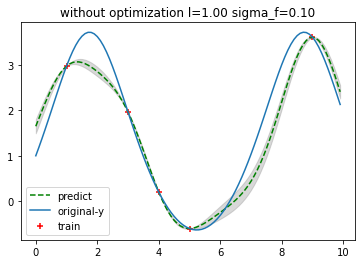

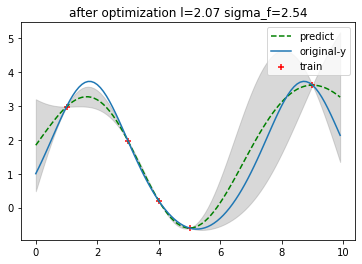

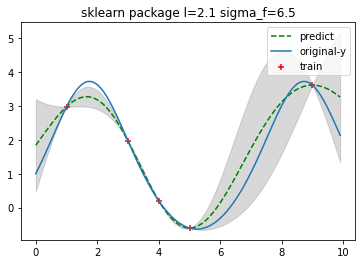

In [4]:
# experiement
train_X = np.array([3, 1, 4, 5, 9]).reshape(-1, 1)
train_y = y_1d(train_X, noise_sigma=1e-4)
test_X = np.arange(0, 10, 0.1).reshape(-1, 1)

gpr = GPR(optimize=False)
gpr.fit(train_X, train_y)
mu, cov = gpr.predict(test_X)
test_y = mu.ravel()
uncertainty = 1.96 * np.sqrt(np.diag(cov))
plt.clf()
plt.figure(1)
plt.title("without optimization l=%.2f sigma_f=%.2f" % (gpr.params["l"],gpr.params["sigma_f"]))
plt.fill_between(test_X.ravel(), test_y + uncertainty, test_y - uncertainty,color='grey', alpha=0.3)
plt.plot(test_X, test_y,'g--', label="predict")
plt.plot(test_X,y_1d(test_X,0.),'-',label="original-y")
plt.scatter(train_X, train_y, label="train", c="red", marker="+")
plt.legend()
plt.savefig('predictive distribution_without training.png')
plt.show()

# after optimize
gpr = GPR(optimize=True)
gpr.fit(train_X, train_y)
mu, cov = gpr.predict(test_X)
test_y = mu.ravel()
uncertainty = 1.96 * np.sqrt(np.diag(cov))
plt.clf()
plt.figure(1)
plt.title("after optimization l=%.2f sigma_f=%.2f" % (gpr.params["l"],gpr.params["sigma_f"]))
plt.fill_between(test_X.ravel(), test_y + uncertainty, test_y - uncertainty,color='grey', alpha=0.3)
plt.plot(test_X, test_y,'g--', label="predict")
plt.plot(test_X,y_1d(test_X,0.),'-',label="original-y")
plt.scatter(train_X, train_y, label="train", c="red", marker="+")
plt.legend()
plt.savefig('predictive distribution_without training.png')
plt.show()

# 1-D与包作对比
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

# fit GPR
kernel = ConstantKernel(constant_value=0.1, constant_value_bounds=(1e-4, 1e4)) * RBF(length_scale=1., length_scale_bounds=(1e-4, 1e4))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=2)
gpr.fit(train_X, train_y)
mu, cov = gpr.predict(test_X, return_cov=True)
test_y = mu.ravel()
uncertainty = 1.96 * np.sqrt(np.diag(cov))

# plotting
plt.figure(2)
plt.title("sklearn package l=%.1f sigma_f=%.1f" % (gpr.kernel_.k2.length_scale, gpr.kernel_.k1.constant_value))
plt.fill_between(test_X.ravel(), test_y + uncertainty, test_y - uncertainty,color='grey', alpha=0.3)
plt.plot(test_X, test_y,'g--', label="predict")
plt.plot(test_X,y_1d(test_X,0.),'-',label="original-y")
plt.scatter(train_X, train_y, label="train", c="red", marker="+")
plt.legend()
plt.savefig('compare with GP package.png')
plt.show()



## 1-D compare with GPy


Name : GP regression
Objective : 9.016795814280194
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |       6.474762686589681  |      +ve      |        
  rbf.lengthscale          |       2.072094122076166  |      +ve      |        
  Gaussian_noise.variance  |  1.1780362505953716e-06  |      +ve      |        


{'dataplot': [<matplotlib.collections.PathCollection at 0x22aa7c11820>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x22aa7c11ca0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x22aa7c11fa0>]}

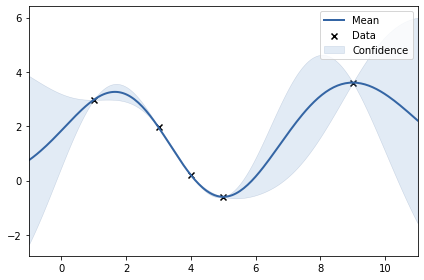

In [10]:
# compare with GPy
import GPy
import warnings
warnings.filterwarnings('ignore')
train_X = np.array([3, 1, 4, 5, 9])[:,None]
#train_X = np.linspace(0, 10, 5)[:,None]
train_y = np.array(y_1d(train_X, noise_sigma=1e-4))
rbf = GPy.kern.RBF(1)
#rbf.lengthscalee=1
#rbf.variance=1
m=GPy.models.GPRegression(train_X,train_y,rbf,normalizer=False)
#print(m)
#m.Gaussian_noise = 1e-4
#m=GPy.examples.regression.olympic_100m_men(optimize=True,plot=True)
# 优化模型
m.optimize()
print(m)
m.plot()

## 2-D simulation

<Figure size 432x288 with 0 Axes>

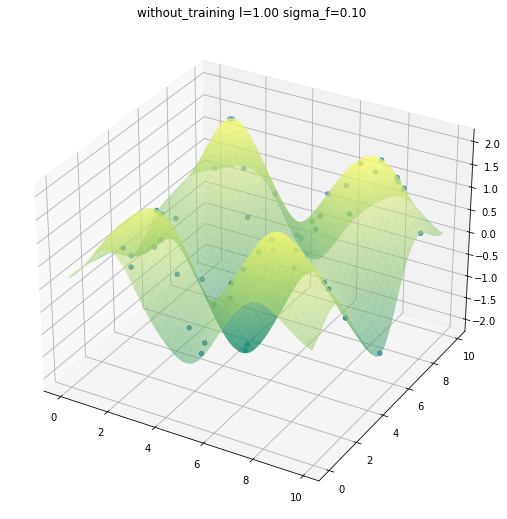

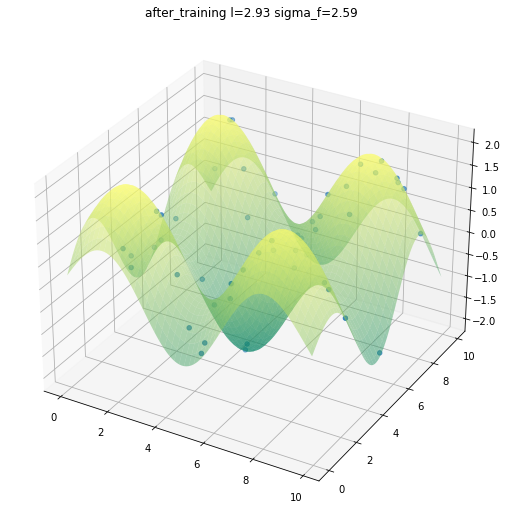

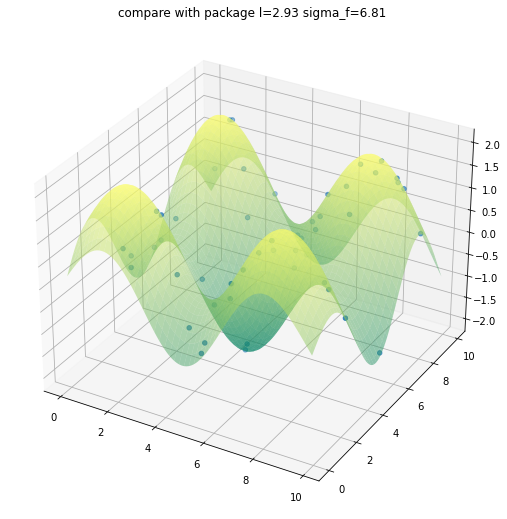

In [11]:
# experiement 2-D
#train_X = np.array([[3, 1, 4, 5, 9],[4,5,6,7,10]]).T
train_X=np.random.uniform(0,10,[50,2])
train_y = y_2d(train_X, noise_sigma=1e-4)
X_test_d1=np.arange(0, 10, 0.1).reshape(-1, 1)
X_test_d2 = np.arange(0, 10, 0.1).reshape(-1, 1)
X_test_d1, X_test_d2 = np.meshgrid(X_test_d1, X_test_d2)  # 构成网格面
test_X = [[d1, d2] for d1, d2 in zip(X_test_d1.ravel(), X_test_d2.ravel())]

gpr = GPR(optimize=False)
gpr.fit(train_X, train_y)
mu, cov = gpr.predict(test_X)
test_y = mu.ravel()
uncertainty = 1.96 * np.sqrt(np.diag(cov))
import mpl_toolkits.axisartist as axisartist
from mpl_toolkits.mplot3d import Axes3D #画三维图不可少
from matplotlib import cm  #cm 是colormap的简写
plt.clf()
fig=plt.figure(figsize=[9,9])
ax=plt.gca(projection='3d')
plt.title("without_training l=%.2f sigma_f=%.2f" % (gpr.params["l"], gpr.params["sigma_f"]))
ax.plot_surface(X_test_d1,X_test_d2,mu.reshape(X_test_d1.shape),cmap='summer',alpha=0.5)
ax.scatter(train_X[:,0],train_X[:,1],train_y)

gpr = GPR(optimize=True)
gpr.fit(train_X, train_y)
mu, cov = gpr.predict(test_X)
test_y = mu.ravel()
uncertainty = 1.96 * np.sqrt(np.diag(cov))

#plt.clf()
fig=plt.figure(figsize=[9,9])
ax=plt.gca(projection='3d')
plt.title("after_training l=%.2f sigma_f=%.2f" % (gpr.params["l"], gpr.params["sigma_f"]))
ax.plot_surface(X_test_d1,X_test_d2,mu.reshape(X_test_d1.shape),cmap='summer',alpha=0.5)
ax.scatter(train_X[:,0],train_X[:,1],train_y)


# 2-D与包作对比
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

# fit GPR
kernel = ConstantKernel(constant_value=0.1, constant_value_bounds=(1e-4, 1e4)) * RBF(length_scale=1., length_scale_bounds=(1e-4, 1e4))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=2)
gpr.fit(train_X, train_y)
mu, cov = gpr.predict(test_X, return_cov=True)
test_y = mu.ravel()
uncertainty = 1.96 * np.sqrt(np.diag(cov))

# plotting
fig=plt.figure(figsize=[9,9])
ax=plt.gca(projection='3d')
plt.title("compare with package l=%.2f sigma_f=%.2f" % (gpr.kernel_.k2.length_scale, gpr.kernel_.k1.constant_value))
ax.plot_surface(X_test_d1,X_test_d2,mu.reshape(X_test_d1.shape),cmap='summer',alpha=0.5)
ax.scatter(train_X[:,0],train_X[:,1],train_y)


## 2-D compare  with GPy

In [12]:
# 2-D与包作对比
import GPy
import warnings
warnings.filterwarnings('ignore')
train_y =np.array(train_y).reshape(-1,1)
rbf=GPy.kern.RBF(2)
m=GPy.models.SparseGPRegression(train_X,train_y,kernel=rbf,num_inducing=50)
print(m)
m.optimize()
print(m)



Name : sparse_gp
Objective : 67.86767592817446
Number of Parameters : 103
Number of Optimization Parameters : 103
Updates : True
Parameters:
  sparse_gp.               |    value  |  constraints  |  priors
  inducing_inputs          |  (50, 2)  |               |        
  rbf.variance             |      1.0  |      +ve      |        
  rbf.lengthscale          |      1.0  |      +ve      |        
  Gaussian_noise.variance  |      1.0  |      +ve      |        

Name : sparse_gp
Objective : -39.9063276052475
Number of Parameters : 103
Number of Optimization Parameters : 103
Updates : True
Parameters:
  sparse_gp.               |                  value  |  constraints  |  priors
  inducing_inputs          |                (50, 2)  |               |        
  rbf.variance             |      5.992083269056552  |      +ve      |        
  rbf.lengthscale          |      2.885701648019881  |      +ve      |        
  Gaussian_noise.variance  |  2.436280007764698e-07  |      +ve      |     

## 1-D BO

In [13]:
# 1-D plot
import matplotlib.pyplot as plt
import numpy as np
def plot_1d(train_X,train_y,test_X,test_y,uncertainty,gen):
    plt.figure(figsize=[19,6])
    plt.subplot(121)
    plt.title("after %d step l=%.2f sigma_f=%.2f" % (gen,gpr.params["l"], gpr.params["sigma_f"]))
    plt.fill_between(test_X.ravel(), test_y + uncertainty, test_y - uncertainty,color='grey', alpha=0.3)
    plt.plot(test_X, test_y,'g--', label="predict",linewidth=4)
    plt.plot(test_X,y_1d(test_X,0.),'-',linewidth=4,label="original-y")
    plt.scatter(train_X, train_y, label="train", c="red", marker="+",s=400)
    plt.xlim(0,8)
    plt.legend()
    
    #draw UCB
    mean=np.array(test_y)
    UCB=mean+1.96*uncertainty
    index=np.argmax(UCB)
    plt.subplot(122)
    plt.title("UCB")
    plt.plot(test_X,mean+1.96*uncertainty,label='utility function',linewidth=4)
    plt.scatter(test_X[index],UCB[index],marker='*',c='red',s=200,label='next best guess')
    plt.legend()
    plt.xlim(0,8)
    plt.show()
    
    return test_X[index]

After 1 step, we have GPR as follows:


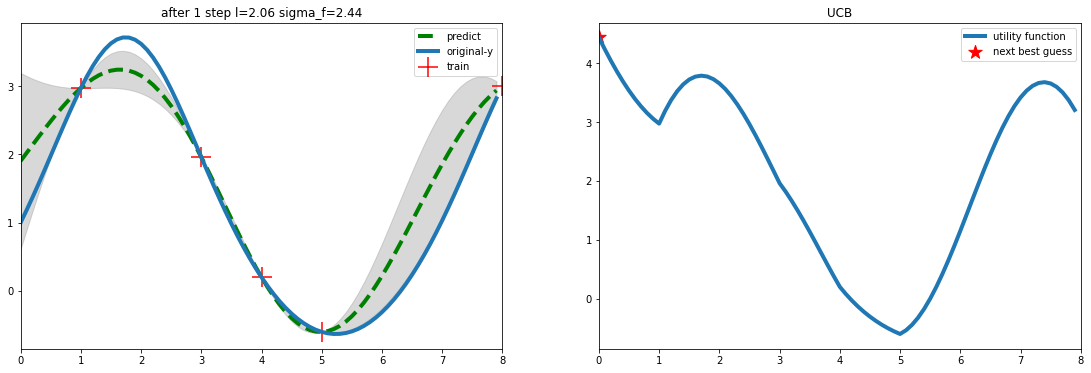

The next best guess is at x=0.00
After 2 step, we have GPR as follows:


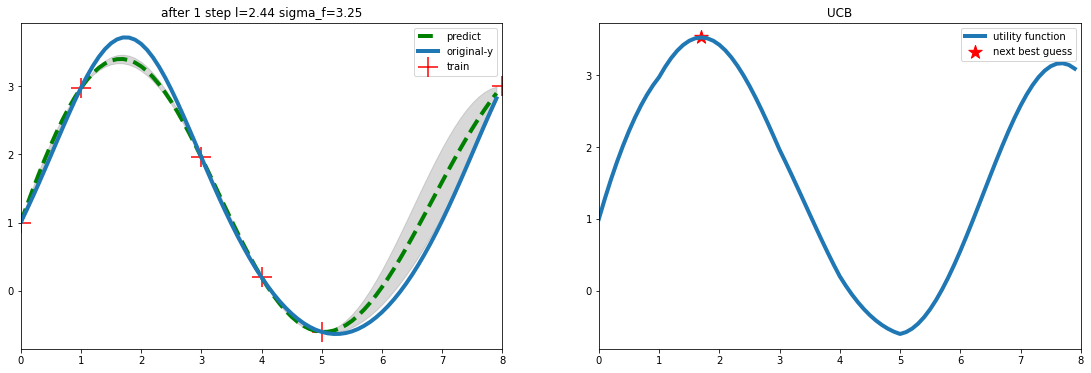

The next best guess is at x=1.70
After 3 step, we have GPR as follows:


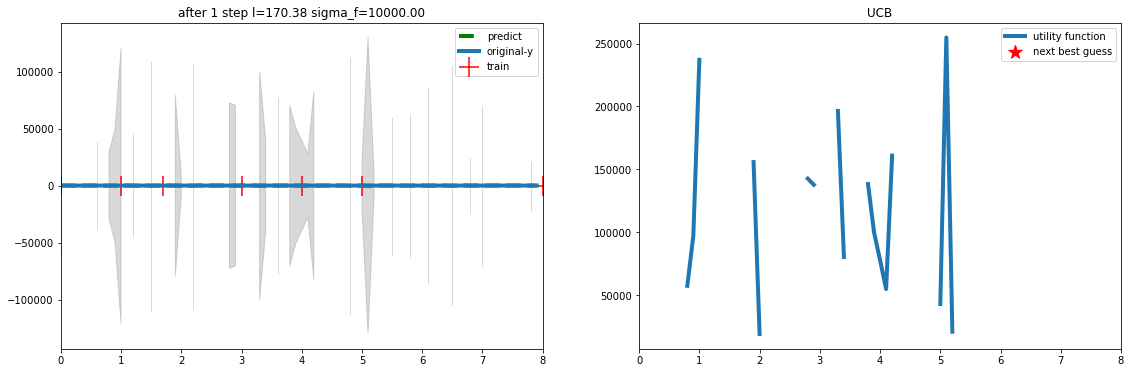

The next best guess is at x=0.10
After 4 step, we have GPR as follows:


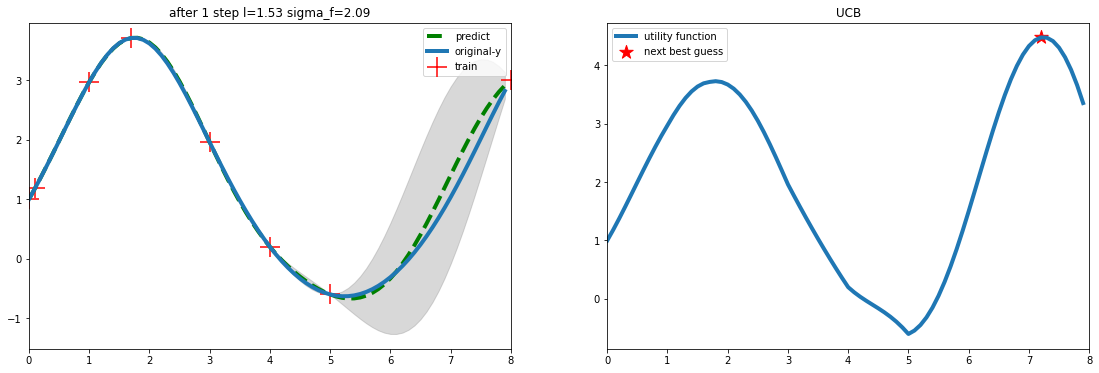

The next best guess is at x=7.20
After 5 step, we have GPR as follows:


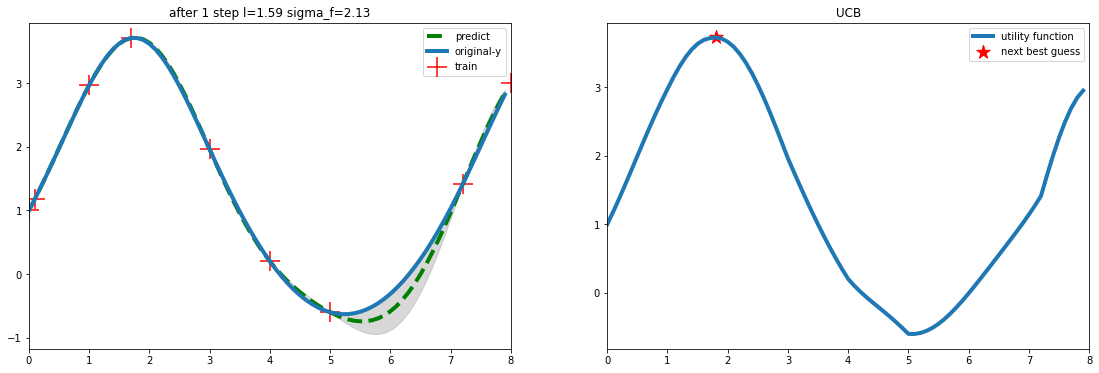

The next best guess is at x=1.80


In [14]:
# experiement
# initialize
train_X = np.array([3, 1, 4, 5,8]).reshape(-1, 1)
train_y = y_1d(train_X, noise_sigma=1e-4)
test_X = np.arange(0, 8, 0.1).reshape(-1, 1)

gen=5
for i in range(gen):
    print("After %d step, we have GPR as follows:" %(i+1))
    gpr = GPR(optimize=True)
    gpr.fit(train_X, train_y)
    mu, cov = gpr.predict(test_X)
    test_y = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    new=plot_1d(train_X,train_y,test_X,test_y,uncertainty,1)
    print("The next best guess is at x=%.2f"%new)
    train_X=np.append(train_X,new).reshape(-1,1)
    train_y = y_1d(train_X, noise_sigma=1e-4)

## 2-D BO

In [15]:
def plot_2d(X_test_d1,X_test_d2,mu,uncertainty,train_X,train_y,gen):
    fig=plt.figure(figsize=[9,9])
    ax=plt.gca(projection='3d')
    plt.title("GPR after %d step"%(gen))
    ax.plot_surface(X_test_d1,X_test_d2,mu.reshape(X_test_d1.shape),cmap='summer',alpha=0.5)
    ax.scatter(train_X[:,0],train_X[:,1],train_y)
    ax.contourf(X_test_d1,X_test_d2,mu.reshape(X_test_d1.shape),zdir='z',offset=-2,cmap='summer',alpha=0.5)
    ax.set(xlim=[0,10],ylim=[0,10])
    plt.savefig('2_d BO_GP.png')
    
    fig=plt.figure(figsize=[9,9])
    ax=plt.gca(projection='3d')
    plt.title("UBC")
    ax.plot_surface(X_test_d1,X_test_d2,(mu+uncertainty).reshape(X_test_d1.shape),cmap='coolwarm')
    
    plt.savefig('2_d BO_UBC.png')

In [16]:
def renew_2d(X_test_d1,mu,uncertainty):
    UCB=(mu+uncertainty).reshape(X_test_d1.shape)
    index=np.argmax(UCB)
    return index//100,index%100

In [17]:
def renew_2d(X_test_d1,mu,uncertainty):
    UCB=(mu+uncertainty).reshape(X_test_d1.shape)
    index=np.argmax(UCB)
    return index//100,index%100

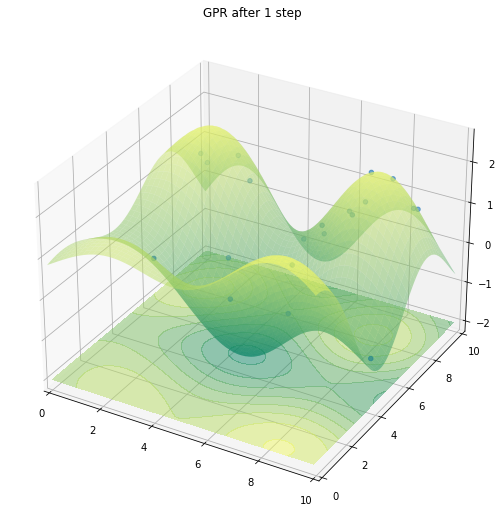

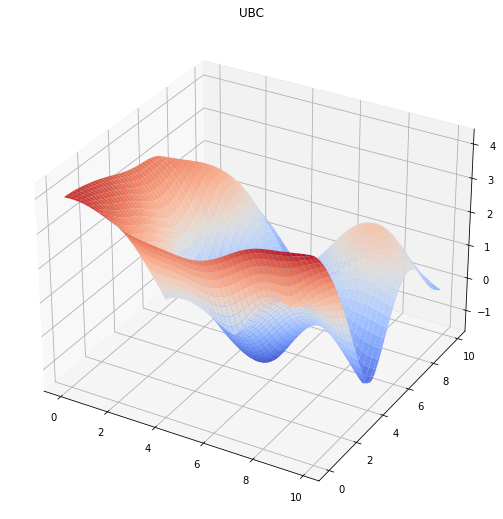

In [24]:
# experiement 2-D
#train_X = np.array([[3, 1, 4, 5, 9],[4,5,6,7,10]]).T
train_X=np.random.uniform(0,10,[20,2])
train_y = y_2d(train_X, noise_sigma=1e-4)
X_test_d1=np.arange(0, 10, 0.1).reshape(-1, 1)
X_test_d2 = np.arange(0, 10, 0.1).reshape(-1, 1)
X_test_d1, X_test_d2 = np.meshgrid(X_test_d1, X_test_d2)  # 构成网格面
test_X = [[d1, d2] for d1, d2 in zip(X_test_d1.ravel(), X_test_d2.ravel())]

gpr = GPR(optimize=True)
gpr.fit(train_X, train_y)
mu, cov = gpr.predict(test_X)
test_y = mu.ravel()
uncertainty = 1.96 * np.sqrt(np.diag(cov))
UCB=mu+uncertainty
plot_2d(X_test_d1,X_test_d2,mu,uncertainty,train_X,train_y,1)

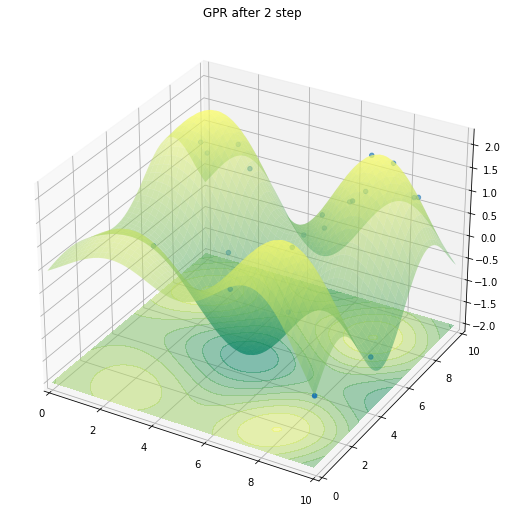

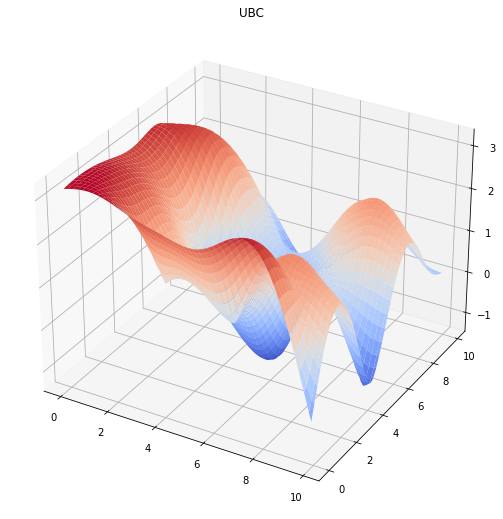

In [25]:
# the second step
index=renew_2d(X_test_d1,mu,uncertainty)
train_X=np.append(train_X,np.array([X_test_d1[index],X_test_d2[index]])).reshape(-1,2)
train_y = y_2d(train_X, noise_sigma=1e-4)
gpr = GPR(optimize=True)
gpr.fit(train_X, train_y)
mu, cov = gpr.predict(test_X)
test_y = mu.ravel()
uncertainty = 1.96 * np.sqrt(np.diag(cov))
UCB=mu+uncertainty
plot_2d(X_test_d1,X_test_d2,mu,uncertainty,train_X,train_y,2)

In [ ]:
# another 5 steps
for i in range(5):
    index=renew_2d(X_test_d1,mu,uncertainty)
    train_X=np.append(train_X,np.array([X_test_d1[index],X_test_d2[index]])).reshape(-1,2)
    train_y = y_2d(train_X, noise_sigma=1e-4)
    gpr = GPR(optimize=True)
    gpr.fit(train_X, train_y)
    mu, cov = gpr.predict(test_X)
    test_y = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    
plot_2d(X_test_d1,X_test_d2,mu,uncertainty,train_X,train_y,7)